<a href="https://colab.research.google.com/github/g-gemini/gemini-notebooks/blob/main/toxicity_detection_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Deep Learning for Comment Toxicity Detection with Streamlit

This notebook contains the complete end-to-end process for building and deploying a comment toxicity detection application. It follows the structured approach outlined in the project description.

**Project Steps:**
1.  **Setup & Data Extraction**: Import libraries and extract the training/testing data from the provided text file.
2.  **Step 1: Data Exploration and Preparation**: Load, clean, and preprocess the comment data.
3.  **Step 2: Model Development**: Build, train, and evaluate a Deep Learning (LSTM) model for multi-label toxicity classification.
4.  **Step 3: Streamlit Application Development**: Write the complete code for the interactive web application to an `app.py` file and launch it.

## 1. Setup & Data Extraction

First, we install and import all the necessary libraries. We will also extract the CSV data embedded within the file and save it into `train.csv` and `test.csv` for use in our project.

In [ ]:


import pandas as pd
import re
import nltk
import pickle
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajsty\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## 2. Step 1: Data Exploration and Preparation

We load the `train.csv` data, explore the distribution of toxicity labels, and define a function to preprocess the comment text by cleaning, removing stopwords, and preparing it for the model.

In [5]:
df_train = pd.read_csv('train.csv')

print("Training Data Shape:", df_train.shape)
print("\nTraining Data Info:")
df_train.info()
print("\nFirst 5 rows of Training Data:")
df_train.head()

Training Data Shape: (159571, 8)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB

First 5 rows of Training Data:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


C:\Users\ajsty\AppData\Local\Temp\ipykernel_23632\987663729.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


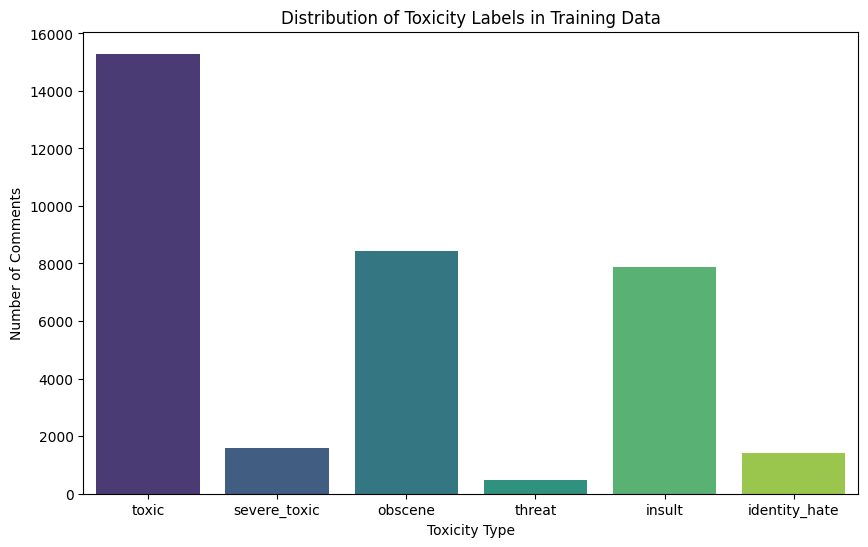

In [6]:
# Explore the distribution of labels
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = df_train[label_cols].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Toxicity Labels in Training Data')
plt.ylabel('Number of Comments')
plt.xlabel('Toxicity Type')
plt.show()

In [7]:
def preprocess_text(text):
    """Cleans and preprocesses text data."""
    # Ensure text is a string
    text = str(text)
    # Remove non-alphabetic characters and convert to lower case
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    # Tokenize and remove stopwords
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return ' '.join(words)

# Apply preprocessing to the comment text
df_train['clean_comment'] = df_train['comment_text'].apply(preprocess_text)

## 3. Step 2: Model Development

Here, we vectorize the text data using Keras's `Tokenizer`, define our LSTM model architecture, compile it, and train it on our preprocessed data.

In [8]:
# Model parameters
MAX_NB_WORDS = 50000  # Max number of words in vocabulary
MAX_SEQUENCE_LENGTH = 250  # Max length of a sequence
EMBEDDING_DIM = 100    # Dimension of the embedding vector

# Vectorize the text data
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
                    lower=True)
tokenizer.fit_on_texts(df_train['clean_comment'].values)
X = tokenizer.texts_to_sequences(df_train['clean_comment'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Define target variables
Y = df_train[label_cols].values

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (159571, 250)
Shape of label tensor: (159571, 6)


In [9]:
# Build the LSTM Model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='sigmoid')) # 6 labels, sigmoid for multi-label classification

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

c:\Users\ajsty\OneDrive - MSFT\Documents\Learn\Python\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 5
batch_size = 64

history = model.fit(X, Y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 598s 265ms/step - accuracy: 0.9798 - loss: 0.0687 - val_accuracy: 0.9940 - val_loss: 0.0519
Epoch 2/5
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 1227s 547ms/step - accuracy: 0.9941 - loss: 0.0445 - val_accuracy: 0.9939 - val_loss: 0.0496
Epoch 3/5
 967/2244 ━━━━━━━━━━━━━━━━━━━━ 5:54 278ms/step - accuracy: 0.9941 - loss: 0.0376

In [ ]:
# Plot training history (for the Streamlit app)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title='Loss Curve')
plt.savefig('loss_curve.png')
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title='Accuracy Curve')
plt.savefig('accuracy_curve.png')

print("Model performance charts saved as 'loss_curve.png' and 'accuracy_curve.png'.")

In [ ]:
# Save the trained model and tokenizer for the Streamlit app
model.save('toxicity_model.h5')

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and tokenizer have been saved.")

## 4. Step 3: Streamlit Application Development

This cell contains the full Python code for our Streamlit application. The `%%writefile app.py` command at the top writes the contents of this cell to a file named `app.py`. We can then run this file using Streamlit.

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import re
import pickle
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# --- Page Configuration ---
st.set_page_config(
    page_title="Comment Toxicity Detection",
    page_icon="🛡️",
    layout="wide"
)

# --- Load Model and Tokenizer (Cached) ---
@st.cache_resource
def load_assets():
    """Loads the pre-trained model and tokenizer."""
    try:
        model = load_model('toxicity_model.h5')
        with open('tokenizer.pickle', 'rb') as handle:
            tokenizer = pickle.load(handle)
        # Download stopwords if not already present
        try:
            stopwords.words('english')
        except LookupError:
            nltk.download('stopwords')
        return model, tokenizer
    except Exception as e:
        st.error(f"Error loading assets: {e}")
        st.error("Please make sure 'toxicity_model.h5' and 'tokenizer.pickle' are in the same directory as app.py.")
        return None, None

model, tokenizer = load_assets()
MAX_SEQUENCE_LENGTH = 250
LABEL_COLS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# --- Preprocessing Function ---
def preprocess_text(text):
    """Cleans and preprocesses text data for prediction."""
    text = str(text)
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return ' '.join(words)

# --- Prediction Function ---
def predict_toxicity(texts):
    """Predicts toxicity for a list of texts."""
    if model is None or tokenizer is None:
        return None
    processed_texts = [preprocess_text(t) for t in texts]
    sequences = tokenizer.texts_to_sequences(processed_texts)
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    predictions = model.predict(padded_sequences)
    return predictions

# --- UI Components ---

def render_prediction_interface(use_case_description):
    st.markdown(f"**Use Case:** {use_case_description}")
    st.write("This tool can be integrated into platforms to automatically flag harmful comments, reducing moderator workload and fostering a safer online environment.")
    st.divider()

    # Single Comment Prediction
    st.subheader("Real-Time Single Comment Analysis")
    user_input = st.text_area("Enter a comment to analyze:", "", height=100, key=f"text_area_{st.session_state.page}")
    if st.button("Analyze Comment", key=f"button_{st.session_state.page}"):
        if user_input:
            with st.spinner('Analyzing...'):
                prediction = predict_toxicity([user_input])
                if prediction is not None:
                    st.write("**Toxicity Analysis Results:**")
                    results_df = pd.DataFrame(prediction, columns=LABEL_COLS)
                    for label in LABEL_COLS:
                        probability = results_df[label][0]
                        st.write(f"**{label.replace('_', ' ').title()}**")
                        st.progress(probability)
                        st.write(f"{probability:.2%}")
        else:
            st.warning("Please enter a comment to analyze.")

    st.divider()

    # Bulk Prediction
    st.subheader("Bulk Comment Analysis via CSV Upload")
    uploaded_file = st.file_uploader("Upload a CSV file with a 'comment_text' column", type=["csv"], key=f"uploader_{st.session_state.page}")
    if uploaded_file is not None:
        try:
            df_bulk = pd.read_csv(uploaded_file)
            if 'comment_text' not in df_bulk.columns:
                st.error("The uploaded CSV must contain a column named 'comment_text'.")
            else:
                st.write("**Uploaded Data Preview:**")
                st.dataframe(df_bulk.head())
                if st.button("Run Bulk Analysis", key=f"bulk_button_{st.session_state.page}"):
                    with st.spinner('Processing bulk data... This may take a while.'):
                        predictions = predict_toxicity(df_bulk['comment_text'].tolist())
                        if predictions is not None:
                            pred_df = pd.DataFrame(predictions, columns=LABEL_COLS)
                            result_df = pd.concat([df_bulk, pred_df], axis=1)
                            st.success("Analysis Complete!")
                            st.dataframe(result_df)

                            # Provide download link
                            csv = result_df.to_csv(index=False).encode('utf-8')
                            st.download_button(
                                label="Download Results as CSV",
                                data=csv,
                                file_name='toxicity_analysis_results.csv',
                                mime='text/csv',
                            )
        except Exception as e:
            st.error(f"An error occurred while processing the file: {e}")

# --- Main Application ---
st.title("🛡️ Deep Learning for Comment Toxicity Detection")

if model is None or tokenizer is None:
    st.stop()

# --- Sidebar Navigation ---
st.sidebar.title("Navigation")
page = st.sidebar.radio("Go to", [
    "Project Overview",
    "Social Media Platforms",
    "Online Forums & Communities",
    "Content Moderation Services",
    "Brand Safety & Reputation",
    "E-learning Platforms",
    "News Websites & Media"
])
st.session_state.page = page # To manage unique keys for widgets

# --- Page Content ---
if page == "Project Overview":
    st.header("Project Overview")
    st.markdown("""
    **Problem Statement:** Online communities face significant challenges from toxic comments, including harassment and hate speech. This project aims to develop an automated system using deep learning to detect and flag toxic comments in real-time, helping to maintain healthy online discourse.
    
    **Approach:**
    1.  **Data Preparation**: Cleaned and preprocessed a dataset of online comments.
    2.  **Model Development**: Trained a Long Short-Term Memory (LSTM) deep learning model to perform multi-label classification on six categories of toxicity.
    3.  **Application**: Built this interactive Streamlit web app for real-time and bulk comment analysis.
    """)
    
    st.subheader("Model Performance")
    col1, col2 = st.columns(2)
    with col1:
        st.image('loss_curve.png', caption='Model Loss over Epochs')
    with col2:
        st.image('accuracy_curve.png', caption='Model Accuracy over Epochs')

elif page == "Social Media Platforms":
    st.header("Use Case: Social Media Platforms")
    render_prediction_interface("Automatically detect and filter toxic comments in real-time to protect users from harassment and abuse.")

elif page == "Online Forums & Communities":
    st.header("Use Case: Online Forums & Communities")
    render_prediction_interface("Integrate toxicity detection to efficiently moderate user-generated content and maintain a constructive community atmosphere.")

elif page == "Content Moderation Services":
    st.header("Use Case: Content Moderation Services")
    render_prediction_interface("Leverage this model to enhance moderation capabilities, providing a scalable solution for clients' platforms.")

elif page == "Brand Safety & Reputation":
    st.header("Use Case: Brand Safety & Reputation Management")
    render_prediction_interface("Ensure that advertisements and sponsored content appear in safe, brand-appropriate online environments by scanning comment sections.")

elif page == "E-learning Platforms":
    st.header("Use Case: E-learning Platforms & Educational Websites")
    render_prediction_interface("Create safer online learning environments by moderating discussion boards and chat features for students and educators.")

elif page == "News Websites & Media":
    st.header("Use Case: News Websites & Media Outlets")
    render_prediction_interface("Utilize toxicity detection to moderate user comments on articles and posts, ensuring discussions remain relevant and civil.")

## 5. Launch the Streamlit Application

Running the cell below will start the Streamlit server. You will see a message with two URLs (Network and External). Open the **External URL** in your browser to interact with the application.